In [1]:
%load_ext autoreload
%autoreload 2

import constants_and_utils as cu
from vaccine_intent import *
from graph_methods import *

import csv
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from scipy import sparse
from scipy.stats import pearsonr, linregress
import pickle
import geopandas as gpd
from statsmodels.discrete.discrete_model import Logit

/home/t-sechang/env/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Preprocessing

## Match holdouts to non-holdouts

In [ ]:
# load user vaccine intent t0s
fn = os.path.join(cu.PATH_TO_PROCESSED_DATA, 'vaccine_intent_users_02_to_08.csv')
user_df = pd.read_csv(fn)
user_df['datetime'] = pd.to_datetime(user_df.datetime)
print(len(user_df))
user_df.head()

In [ ]:
# load user summaries (num months active, avg query counts)
summary_df_small = pd.read_csv(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'active_user_summary_small_02_to_08.csv'))
summary_df_small.head()

In [4]:
# holdouts: active every month, t0 past July 1
# non-holdouts: active every month, t0 before May 1
longterm_users = summary_df_small.ClientId[summary_df_small.NumMonthsActive == 7].values
user_df['longterm_user'] = user_df.ClientId.isin(longterm_users)
user_df['is_holdout'] = user_df.longterm_user & (user_df.datetime >= datetime.datetime(2021, 7, 1))
user_df['is_nonholdout'] = user_df.longterm_user & (user_df.datetime < datetime.datetime(2021, 5, 1))
print(user_df.is_holdout.sum(), user_df.is_nonholdout.sum())

220825 1747778


In [13]:
# only keep users with county
mode_prop = user_df['MaxCountyCount'] / user_df['QueryCountWithCounty']
level_bools = (user_df['QueryCountWithCounty'] >= 10) & (mode_prop >= 0.25)
print('Can assign %d (%.2f%%) of vaccine intent users to County' % 
      (level_bools.sum(), 100. * level_bools.sum() / len(user_df)))
county_user_df = user_df[level_bools]

Can assign 7290960 (97.90%) of vaccine intent users to County


In [16]:
# match holdouts and nonholdouts
holdout_df = county_user_df[county_user_df.is_holdout].merge(summary_df_small, how='left', left_on='ClientId', right_on='ClientId')
nonholdout_df = county_user_df[county_user_df.is_nonholdout].merge(summary_df_small, how='left', left_on='ClientId', right_on='ClientId')
G, matched_holdouts, matched_nonholdouts = make_holdout_nonholdout_matched_pairs(holdout_df, nonholdout_df, tol=10)

Starting state 1
Starting state 2
Starting state 4
Starting state 5
Starting state 6
Starting state 8
Starting state 9
Starting state 10
Starting state 11
Starting state 12
Starting state 13
Starting state 15
Starting state 16
Starting state 17
Starting state 18
Starting state 19
Starting state 20
Starting state 21
Starting state 22
Starting state 23
Starting state 24
Starting state 25
Starting state 26
Starting state 27
Starting state 28
Starting state 29
Starting state 30
Starting state 31
Starting state 32
Starting state 33
Starting state 34
Starting state 35
Starting state 36
Starting state 37
Starting state 38
Starting state 39
Starting state 40
Starting state 41
Starting state 42
Starting state 44
Starting state 45
Starting state 46
Starting state 47
Starting state 48
Starting state 49
Starting state 50
Starting state 51
Starting state 53
Starting state 54
Starting state 55
Starting state 56
Finished making bipartite graph [time=413.159s]
Matched 212283 holdouts (97.91%) [time=69

In [17]:
# checks that our matching did what it was supposed to
matched_holdout_df = holdout_df.set_index('ClientId').loc[matched_holdouts]
matched_nonholdout_df = nonholdout_df.set_index('ClientId').loc[matched_nonholdouts]
diffs = matched_nonholdout_df.AvgQueryCount.values - matched_holdout_df.AvgQueryCount.values
assert all(np.abs(diffs) <= 10)
same_county = matched_nonholdout_df.MaxCounty.values == matched_holdout_df.MaxCounty.values
assert all(same_county)

In [ ]:
pairs_df = pd.DataFrame({'holdout': matched_holdouts, 
                         'holdout_datetime': matched_holdout_df.datetime.values,
                         'holdout_avg_qc': matched_holdout_df.AvgQueryCount.values,
                         'nonholdout': matched_nonholdouts, 
                         'nonholdout_datetime': matched_nonholdout_df.datetime.values,
                         'nonholdout_avg_qc': matched_nonholdout_df.AvgQueryCount.values,
                         'county': matched_holdout_df.MaxCounty.values})
print(pairs_df[['holdout_avg_qc', 'nonholdout_avg_qc']].mean())
pairs_df.to_csv(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'matched_users.tsv'), sep='\t', index=False)
pairs_df.head()

## Make Apr-Jun click summary per user

In [ ]:
# load all holdout and nonholdout clicks from Apr to Jun
amt_pos_urls, gnn_pos_urls = load_positive_urls()
print(len(amt_pos_urls), len(gnn_pos_urls))
all_pos_urls = np.concatenate([amt_pos_urls, gnn_pos_urls])

holdout_dfs = []
nonholdout_dfs = []
for date_range in cu.DATE_RANGES[4:7]:
    print('holdouts', date_range)
    holdout_df = get_clicks_for_date_range('holdout', date_range, only_vaccine_or_covid=False, all_pos_urls=all_pos_urls)
    holdout_df['date_range'] = date_range
    holdout_dfs.append(holdout_df)
    print('nonholdouts', date_range)
    nonholdout_df = get_clicks_for_date_range('nonholdout', date_range, only_vaccine_or_covid=False, all_pos_urls=all_pos_urls)
    nonholdout_df['date_range'] = date_range 
    nonholdout_dfs.append(nonholdout_df)
holdout_df = pd.concat(holdout_dfs)
nonholdout_df = pd.concat(nonholdout_dfs)

In [ ]:
holdout_df['label'] = 1
nonholdout_df['label'] = 0
combined_df = pd.concat([holdout_df, nonholdout_df])
print(len(combined_df))
combined_df.head()

In [ ]:
# make apr-jun click summary per user
props = combined_df.groupby('ClientId')[['about_vaccine', 'is_pos_url', 'about_vaccine_and_not_pos']].mean()
num_clicks = combined_df.groupby('ClientId').size().rename('num_clicks')
labels = combined_df.groupby('ClientId')['label'].max()
cid_df = props.merge(num_clicks, how='left', left_index=True, right_index=True).merge(labels, how='left', left_index=True, right_index=True)
cid_df = cid_df[cid_df.num_clicks >= 10]
print(cid_df.label.value_counts())
cid_df.to_csv(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'matched_holdout_click_summary_04_06.csv'))
cid_df.head()

## Merge summary with ZCTA info

In [13]:
cid_df = pd.read_csv(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'matched_holdout_click_summary_04_06.csv')).set_index('ClientId')

# load vaccine intent time
fn = os.path.join(cu.PATH_TO_PROCESSED_DATA, 'vaccine_intent_users_02_to_08.csv')
user_df = pd.read_csv(fn, low_memory=False)
user_df['datetime'] = pd.to_datetime(user_df.datetime)
user_df = user_df[['ClientId', 'datetime', 'MaxZip', 'MaxZipCount', 'QueryCountWithZip', 
                   'MaxCounty', 'MaxState']].set_index('ClientId')
cid_df = cid_df.merge(user_df, left_index=True, right_index=True, how='left')
assert cid_df.datetime.isna().sum() == 0  # we should be able to find t0 for all ClientIds

# add ZCTA
mode_prop = cid_df['MaxZipCount'] / cid_df['QueryCountWithZip']
zcta_cid_df = cid_df[(cid_df.QueryCountWithZip >= 10) & (mode_prop >= 0.25)].copy()
print('Can assign %d (%.2f%%) of matched holdouts and nonholdouts to Zip' % (len(zcta_cid_df),
                100 * len(zcta_cid_df) / len(cid_df)))
zip_zcta_df = get_zip_to_zcta_df()
zip2zcta = dict(zip(zip_zcta_df.index, zip_zcta_df.ZCTA))
zcta_cid_df['ZCTA'] = zcta_cid_df.MaxZip.apply(lambda z: zip2zcta.get(z, np.nan)) # map ZIP to ZCTA
print('Missing ZCTA:', zcta_cid_df.ZCTA.isna().mean())
zcta_cid_df = zcta_cid_df.dropna(subset=['ZCTA'])

Can assign 414988 (99.05%) of matched holdouts and nonholdouts to Zip
Loaded zip code to ZCTA dataframe; found 41099 zip codes
Missing ZCTA: 0.000445796023017533


In [14]:
# add ZCTA demo data
zcta_df = get_zcta_df(include_lat_lon=True)
county_election_df = cu.get_county_election_df()
zcta_df = zcta_df.merge(county_election_df['prop_rep'], how='left', left_on='county', right_index=True)

zcta_cid_df = zcta_cid_df.merge(zcta_df, left_on='ZCTA', right_index=True, how='left')
missing = zcta_cid_df.county.isna()
print('Missing ZCTA demo:', missing.mean())
zcta_cid_df = zcta_cid_df.dropna(subset='county')
agree = zcta_cid_df.MaxCounty == zcta_cid_df.county
print('County agrees:', agree.mean())
zcta_cid_df.label.value_counts()

Loaded ZCTA to county mapping; found 33791 ZCTAs
Loaded zip code to ZCTA dataframe; found 41099 zip codes
Loaded ZCTA to state mapping; found 33139 ZCTAs


/home/t-sechang/git_src/constants_and_utils.py:659: RuntimeWarning: invalid value encountered in divide
  zcta_df['percent_bachelor_or_higher'] = np.round(100. * zcta_df['num_25+_bachelor_or_higher'].values / zcta_df['num_25+'].values, 1)  # to match other percents


Finished loading all ZCTA data; found 33791 ZCTAs in total
SimpleMaps population vs ACS total_pop: N=32714, correlation = 1.000
SimpleMaps density vs ACS pop_per_sq_meter: N=32714, correlation = 1.000
Loaded county-level election data; found 3155 FIPS
Missing ZCTA demo: 7.47342714493386e-05
County agrees: 0.9688358905615615


0    207698
1    207074
Name: label, dtype: int64

In [ ]:
# add ZCTA coverage
kept_zcta_df = cu.load_bing_coverage_per_zcta(zcta_df, zip2zcta=zip2zcta, min_pop_size=50)
zcta_cid_df = zcta_cid_df.merge(kept_zcta_df.coverage, left_on='ZCTA', right_index=True, how='left')

In [16]:
# fill in missing coverage
print('Missing coverage:', zcta_cid_df.coverage.isna().mean())
median_coverage = np.nanmedian(zcta_cid_df.coverage.values)
zcta_cid_df['coverage'] = zcta_cid_df.coverage.fillna(median_coverage)
assert zcta_cid_df.coverage.isna().sum() == 0
zcta_cid_df['inverse_coverage'] = 1/zcta_cid_df.coverage

Missing coverage: 0.009303906724658367


# Apr-Jun: news consumption stats

In [85]:
# get document per user of domains visited 
def make_user_doc(user_subdf):
    clicks = list(user_subdf.domain.values)
    return ' '.join(clicks)
 
combined_df['domain'] = combined_df.NormalizedUrl.apply(cu.get_domain_from_http_url)   
cids = cid_df.index.values
ts = time.time()
user_domain_docs = combined_df.groupby('ClientId').apply(make_user_doc).loc[cids]
print('Made user docs [time=%.3fs]' % (time.time()-ts))

Made user docs [time=111.380s]


In [ ]:
# counts per user and domain
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

fn = '../data/newsguard_complete_data.xlsx'
newsguard_df = pd.read_excel(fn)
domains = newsguard_df.Domain.unique()

cv = CountVectorizer(token_pattern=r"\S{3,}", vocabulary=domains)
user_domain_counts = cv.transform(user_domain_docs)
print(user_domain_counts.shape)
assert all(cv.get_feature_names_out() == domains)

with open(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'newsguard_domains.pkl'), 'wb') as f:
    pickle.dump(domains, f)
sparse.save_npz(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'matched_holdout_domain_counts_04_06.npz'), user_domain_counts)

In [19]:
# load Newsguard scores and ratings
domain2score, domain2rating = cu.get_newsguard_domain_to_scores()

Found 7147 domains with scores, 7226 domains with ratings


In [ ]:
# load counts per user + domain, merge with user info
user_domain_counts = sparse.load_npz(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'matched_holdout_domain_counts_04_06.npz'))
with open(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'newsguard_domains.pkl'), 'rb') as f:
    domains = pickle.load(f)
assert user_domain_counts.shape == (len(cid_df), len(domains))
user_domain_counts = user_domain_counts.toarray()
all_vals = np.concatenate([cid_df.values, user_domain_counts], axis=1)
cid_domain_df = pd.DataFrame(all_vals, columns=list(cid_df.columns)+list(domains))
cid_domain_df['any_news'] = np.sum(user_domain_counts, axis=1)
cid_domain_df = cid_domain_df.set_index(cid_df.index)
print(len(cid_domain_df))

# add ZCTA info to cid_domain_df
cid_domain_df = cid_domain_df.merge(zcta_cid_df[['MaxState', 'MaxCounty', 'ZCTA', 'inverse_coverage']], how='inner',
                                    left_index=True, right_index=True)
print(len(cid_domain_df))  # should be slightly smaller
cid_domain_df.head()

In [10]:
# how much likelier are holdouts than nonholdouts to click on news at all
cid_domain_df['prop_news'] = cid_domain_df['any_news'] / cid_domain_df['num_clicks']
holdouts = cid_domain_df[cid_domain_df.label == 1]
nonholdouts = cid_domain_df[cid_domain_df.label == 0]

# user-level averages
holdout_mean = (holdouts.prop_news * holdouts.inverse_coverage).sum() / holdouts.inverse_coverage.sum()
nonholdout_mean = (nonholdouts.prop_news * nonholdouts.inverse_coverage).sum() / nonholdouts.inverse_coverage.sum()
print('Holdout mean = %.4f, nonholdout mean = %.4f' % (holdout_mean, nonholdout_mean))

# click-level averages
holdout_mean = (holdouts.any_news * holdouts.inverse_coverage).sum() / (holdouts.num_clicks * holdouts.inverse_coverage).sum()
nonholdout_mean = (nonholdouts.any_news * nonholdouts.inverse_coverage).sum() / (nonholdouts.num_clicks * nonholdouts.inverse_coverage).sum()
print('Holdout mean = %.4f, nonholdout mean = %.4f' % (holdout_mean, nonholdout_mean))

Holdout mean = 0.1221, nonholdout mean = 0.1287
Holdout mean = 0.1334, nonholdout mean = 0.1383


In [46]:
# get proportion of news clicks that are untrusted
untrusted_cols = [d for d in domains if domain2rating.get(d, 'None') == 'N']
print('Found %d untrusted domains' % (len(untrusted_cols)))
holdout_untrusted_counts = holdouts[untrusted_cols].sum(axis=1)
holdout_mean = (holdout_untrusted_counts * holdouts.inverse_coverage).sum() / (holdouts.any_news * holdouts.inverse_coverage).sum()
nonholdout_untrusted_counts = nonholdouts[untrusted_cols].sum(axis=1)
nonholdout_mean = (nonholdout_untrusted_counts * nonholdouts.inverse_coverage).sum() / (nonholdouts.any_news * nonholdouts.inverse_coverage).sum()
print('Holdout mean = %.4f, nonholdout mean = %.4f, ratio = %.4f' % (holdout_mean, nonholdout_mean, holdout_mean / nonholdout_mean))

Found 2744 untrusted domains
Holdout mean = 0.0363, nonholdout mean = 0.0215, ratio = 1.6851


In [50]:
# bootstrap samples to compute CI for untrusted ratio
num_trials = 1000
holdout_means = []
nonholdout_means = []
for t in range(num_trials):
    if t % 100 == 0:
        print(t)
    news_p = holdouts.any_news / holdouts.any_news.sum()
    news_counts_s = np.random.multinomial(holdouts.any_news.sum(), news_p)  # num news clicks from each holdout in sample
    positive_news = news_counts_s > 0  # holdouts with positive number of clicks in sample
    untrusted_p = holdout_untrusted_counts[positive_news] / holdouts.any_news[positive_news]
    untrusted_counts_s = np.zeros(len(holdouts))
    untrusted_counts_s[positive_news] = np.random.binomial(news_counts_s[positive_news], untrusted_p)
    holdout_mean = (untrusted_counts_s * holdouts.inverse_coverage).sum() / (news_counts_s * holdouts.inverse_coverage).sum()
    holdout_means.append(holdout_mean)
    
    news_p = nonholdouts.any_news / nonholdouts.any_news.sum()
    news_counts_s = np.random.multinomial(nonholdouts.any_news.sum(), news_p)  # num news clicks from each nonholdout in sample
    positive_news = news_counts_s > 0  # nonholdouts with positive number of clicks in sample
    untrusted_p = nonholdout_untrusted_counts[positive_news] / nonholdouts.any_news[positive_news]
    untrusted_counts_s = np.zeros(len(nonholdouts))
    untrusted_counts_s[positive_news] = np.random.binomial(news_counts_s[positive_news], untrusted_p)
    nonholdout_mean = (untrusted_counts_s * nonholdouts.inverse_coverage).sum() / (news_counts_s * nonholdouts.inverse_coverage).sum()
    nonholdout_means.append(nonholdout_mean)
summary = pd.DataFrame({'holdout_mean': holdout_means, 'nonholdout_mean': nonholdout_means})
summary['ratio'] = summary.holdout_mean / summary.nonholdout_mean
summary.describe(percentiles=[0.025, 0.975])

0
100
200
300
400
500
600
700
800
900


,holdout_mean,nonholdout_mean,ratio
count,1000.000000,1000.000000,1000.000000
mean,0.036313,0.021550,1.685114
std,0.000075,0.000055,0.005628
min,0.036112,0.021391,1.668038
2.5%,0.036161,0.021442,1.673705
50%,0.036315,0.021549,1.685170
97.5%,0.036463,0.021656,1.696220
max,0.036528,0.021735,1.701641


In [11]:
# per domain:
# numerator: \sum_user num_domain_clicks * inverse_coverage
# denominator: \sum_user num_news_clicks * inverse_coverage
weights = holdouts.inverse_coverage.values  # num_holdouts
user_domain_counts = holdouts[domains].values  # num_holdouts x num_cols
user_news_counts = holdouts.any_news.values  # num_holdouts
weighted_numerators = np.sum(user_domain_counts * weights[:, np.newaxis], axis=0)  # multiply each col by weights
weighted_denominators = np.sum(np.ones(user_domain_counts.shape) * (user_news_counts*weights)[:, np.newaxis], axis=0)
holdout_means = weighted_numerators / weighted_denominators

weights = nonholdouts.inverse_coverage.values  
user_domain_counts = nonholdouts[domains].values 
user_news_counts = nonholdouts.any_news.values 
weighted_numerators = np.sum(user_domain_counts * weights[:, np.newaxis], axis=0)  # multiply each col by weights
weighted_denominators = np.sum(np.ones(user_domain_counts.shape) * (user_news_counts*weights)[:, np.newaxis], axis=0)
nonholdout_means = weighted_numerators / weighted_denominators

holdout_means = holdout_means.astype(float)
nonholdout_means = nonholdout_means.astype(float)
min_prop = 1e-6
passes_min = (holdout_means >= min_prop) & (nonholdout_means >= min_prop)
print(passes_min.sum())
weighted_domain_df = pd.DataFrame({'domain': domains[passes_min], 
             'holdout_prop_clicks': holdout_means[passes_min], 
             'nonholdout_prop_clicks': nonholdout_means[passes_min], 
             'avg_prop_clicks': (holdout_means[passes_min]+nonholdout_means[passes_min])/2,
             'risk_ratio': holdout_means[passes_min]/nonholdout_means[passes_min],
             'newsguard_score': [domain2score[d] for d in domains[passes_min]],
             'newsguard_rating': [domain2rating[d] for d in domains[passes_min]]})
weighted_domain_df[weighted_domain_df.domain.isin(cu.NEWS_DOMAINS)].sort_values('risk_ratio', ascending=False)

3282


,domain,holdout_prop_clicks,nonholdout_prop_clicks,avg_prop_clicks,risk_ratio,newsguard_score,newsguard_rating
2429,foxnews.com,0.032074,0.025758,0.028916,1.245176,69.5,T
1824,nypost.com,0.008316,0.007443,0.007879,1.117227,69.5,T
721,dailymail.co.uk,0.009548,0.009045,0.009296,1.055549,64.5,T
548,forbes.com,0.006879,0.006581,0.006730,1.045375,100.0,T
2198,huffpost.com,0.004207,0.004084,0.004145,1.030043,87.5,T
2805,bbc.co.uk,0.000742,0.000724,0.000733,1.024034,95.0,T
2419,theguardian.com,0.003219,0.003289,0.003254,0.978624,100.0,T
219,businessinsider.com,0.003304,0.003535,0.003420,0.934474,100.0,T
169,wsj.com,0.001861,0.002041,0.001951,0.912258,100.0,T
585,cnbc.com,0.005045,0.005729,0.005387,0.880552,95.0,T


Visualizing 3179 domains
Found 8 domains to label


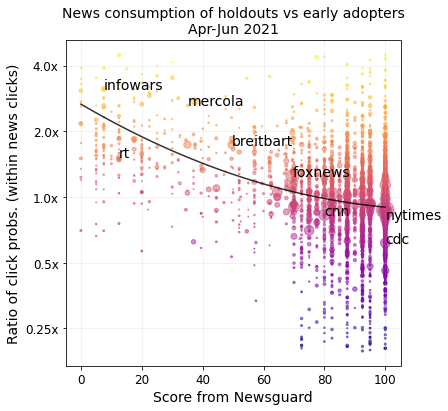

In [27]:
# visualize news results
yticks = np.array([.25, .5, 1, 2, 4])
min_ratio = weighted_domain_df.risk_ratio.quantile(0.01)
max_ratio = weighted_domain_df.risk_ratio.quantile(0.99)
to_label = ['foxnews.com', 'cnn.com', 'cdc.gov', 'nytimes.com', 
            'breitbart.com', 'infowars.com', 'rt.com', 'mercola.com']
ax = plot_holdout_vs_nonholdout_domain_risk_ratio(weighted_domain_df, yticks=yticks,
                                             min_ratio=min_ratio, max_ratio=max_ratio,
                                             to_label=to_label)
plt.savefig(os.path.join(PATH_TO_RESULTS, 'holdout_vs_nonholdout_news.pdf'), bbox_inches='tight')

# Ontology construction

In [ ]:
# construct collapsed URL-URL graph for vaccine and COVID-related URLs
def keep_vaccine_and_covid_url(norm_url):
    if skip_url_label(norm_url):  # drop internal, drop ads
        return False
    keywords = ['covid', 'coronavirus', 'vaccin', 'vax']
    if any([k in norm_url for k in keywords]):
        return True
    return False

date_ranges = cu.DATE_RANGES[4:]
print(date_ranges)
G, query_list, url_list = load_qu_pairs_for_matched_users_as_bipartite_matrix(date_ranges, keep_url_func=keep_vaccine_and_covid_url)
with open(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'matched_users_qu_graph_04_08_nodes.pkl'), 'wb') as f:
    pickle.dump((query_list, url_list), f)
sparse.save_npz(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'matched_users_qu_graph_04_08.npz'), G)

B_U = G.T @ G  # collapsed, URLs
print((B_U != B_U.T).sum())  # should be symmetric
with open(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'matched_users_url_graph_04_08_nodes.pkl'), 'wb') as f:
    pickle.dump(url_list, f)
sparse.save_npz(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'matched_users_url_graph_04_08.npz'), B_U)

In [ ]:
# load and save vaccine and COVID-related clicks from Apr to Aug 
amt_pos_urls, gnn_pos_urls = load_positive_urls()
print(len(amt_pos_urls), len(gnn_pos_urls))
all_pos_urls = np.concatenate([amt_pos_urls, gnn_pos_urls])

holdout_dfs = []
nonholdout_dfs = []
for date_range in cu.DATE_RANGES[4:]:
    print('holdouts', date_range)
    holdout_df = get_vaccine_and_covid_clicks_for_date_range('holdout', date_range, all_pos_urls)
    holdout_df['date_range'] = date_range
    holdout_dfs.append(holdout_df)
    print('nonholdouts', date_range)
    nonholdout_df = get_vaccine_and_covid_clicks_for_date_range('nonholdout', date_range, all_pos_urls)
    nonholdout_df['date_range'] = date_range 
    nonholdout_dfs.append(nonholdout_df)
holdout_df = pd.concat(holdout_dfs)
nonholdout_df = pd.concat(nonholdout_dfs)

holdout_df['label'] = 1
nonholdout_df['label'] = 0
combined_df = pd.concat([holdout_df, nonholdout_df])
del combined_df['ClickUrl']
combined_df.to_csv(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'matched_users_vaccine_covid_clicks_04_08_with_date.csv'), index=False)

In [21]:
# community detection on vaccine-related URLs with optimized resolution (r=17)
vaccine_clicks = combined_df[combined_df.about_vaccine & (~combined_df.is_pos_url)]
print(len(vaccine_clicks))
result_df = run_community_detection_experiment(vaccine_clicks, graph_name='matched_users_url_graph_04_08', mod_res=17)
result_df.round(4).to_csv(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'matched_users_vaccine_topics_04_08_r17.csv'), index=False)

1134162
Keeping 32811 out of 250948 URLs with at least 5 users
Found 32810 out of 32811 URLs in graph
Original subgraph: shape = (32810, 32810), num edges = 2273234
Keeping 30294 out of 32810 nodes in component of at least size 10
Total modularity: 0.3359 [resolution = 17]
Number of communities: 728


In [22]:
# load initial URL-topic assignments and topic labels
result_df, topic_df = load_topics_and_descriptions(result_fn='matched_users_vaccine_topics_04_08_r17.csv',
                             description_fn='vaccine_topic_r17_descriptions_final2.xlsx',
                             min_topic_size=30)
print('Num topics with >= 100 URLs:', (topic_df.topic_size >= 100).sum())
for l in [None, 'MISC', 'REDO']:
    if l is None:
        subset = topic_df[~topic_df.Label1.isin({'MISC', 'REDO'})]
    else:
        subset = topic_df[topic_df.Label1 == l]
    print('%s: num topics = %d. num URLs = %d (%.2f%%). num clicks = %d (%.2f%%).' % 
          (l, len(subset), subset.topic_size.sum(), 100*subset.topic_size.sum() / topic_df.topic_size.sum(),
           subset.topic_clicks.sum(), 100*subset.topic_clicks.sum() / topic_df.topic_clicks.sum()))    
topic_df.head()

Num topics with >= 100 URLs: 79
None: num topics = 126. num URLs = 22872 (82.12%). num clicks = 626050 (86.42%).
MISC: num topics = 14. num URLs = 1032 (3.71%). num clicks = 17331 (2.39%).
REDO: num topics = 13. num URLs = 3948 (14.17%). num clicks = 81009 (11.18%).


/home/t-sechang/env/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,topic_size,topic_clicks,Description,Clear,Subcategory,Label1,Label2
Topic,,,,,,,
0,48,2034,Eric Clapton anti vax,Y,High-profile anti-vax,C-FigureAnti,NaN
1,206,5972,CDC mask guidance for vaccinated,Y,Post-vax guidelines,I-PostVax,NaN
2,139,4927,"VAERS, vaccine deaths, vaccine safety + fear",Y,Vaccine-caused deaths,S-Deaths,NaN
3,137,6488,Religious exemption for vaccine,Y,Exemption,R-Exemption,C-Religious
4,113,4072,"J+J vaccine side effects: mostly normal, a few...",Y,Normal side effects,S-Normal,I-J&J


In [33]:
# rerun community detection on unclear topics
all_redone_df = []
for topic, row in topic_df[topic_df.Label1 == 'REDO'].iterrows():
    print('Topic', topic)
    urls_to_group = result_df[result_df.topic == topic].url.values
    assert len(urls_to_group) == topic_df.loc[topic].Size
    topic_results_df = run_community_detection_experiment(vaccine_clicks, graph_name='matched_users_url_graph_04_08', 
                                                          urls_to_group=urls_to_group)
    cols = list(topic_results_df.columns)
    topic_results_df['orig_topic'] = topic
    topic_results_df = topic_results_df[['orig_topic'] + cols] # set orig_topic as first column
    all_redone_df.append(topic_results_df)
    print()
all_redone_df = pd.concat(all_redone_df)
all_redone_df.round(4).to_csv(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'matched_users_vaccine_topics_04_08_REDO.csv'), index=False)

Topic 22
Grouping 591 URLs
Found 591 out of 591 URLs in graph
Original subgraph: shape = (591, 591), num edges = 28387
Keeping 591 out of 591 nodes in component of at least size 10
Total modularity: 0.3639 [resolution = 1]
Number of communities: 9

Topic 30
Grouping 499 URLs
Found 499 out of 499 URLs in graph
Original subgraph: shape = (499, 499), num edges = 115883
Keeping 499 out of 499 nodes in component of at least size 10
Total modularity: 0.2098 [resolution = 1]
Number of communities: 7

Topic 35
Grouping 209 URLs
Found 209 out of 209 URLs in graph
Original subgraph: shape = (209, 209), num edges = 22483
Keeping 209 out of 209 nodes in component of at least size 10
Total modularity: 0.1187 [resolution = 1]
Number of communities: 14

Topic 49
Grouping 208 URLs
Found 208 out of 208 URLs in graph
Original subgraph: shape = (208, 208), num edges = 10828
Keeping 208 out of 208 nodes in component of at least size 10
Total modularity: 0.4332 [resolution = 1]
Number of communities: 17

T

In [23]:
# load redone URL-topic assignments and topic labels
redo_result_df, redo_topic_df = load_topics_and_descriptions(result_fn='matched_users_vaccine_topics_04_08_REDO.csv',
                             description_fn='vaccine_topic_descriptions_REDO.xlsx',
                             min_topic_size=20)
for l in [None, 'MISC', 'REDO']:
    if l is None:
        subset = redo_topic_df[~redo_topic_df.Label1.isin({'MISC', 'REDO'})]
    else:
        subset = redo_topic_df[redo_topic_df.Label1 == l]
    print('%s: num topics = %d. num URLs = %d (%.2f%%). num clicks = %d (%.2f%%).' % 
          (l, len(subset), subset.topic_size.sum(), 100*subset.topic_size.sum() / redo_topic_df.topic_size.sum(),
           subset.topic_clicks.sum(), 100*subset.topic_clicks.sum() / redo_topic_df.topic_clicks.sum()))
redo_topic_df.head()

None: num topics = 30. num URLs = 1854 (54.63%). num clicks = 47193 (66.60%).
MISC: num topics = 18. num URLs = 1540 (45.37%). num clicks = 23664 (33.40%).
REDO: num topics = 0. num URLs = 0 (0.00%). num clicks = 0 (0.00%).


/home/t-sechang/env/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,topic_size,topic_clicks,Orig Topic,Description,Clear,Label1,Label2
Topic,,,,,,,
22-0,70,3198,22.0,Fake vaccine card,Y,R-FakeProof,NaN
22-1,145,3079,22.0,Mix of fake and real vaccine card,M,R-Proof,NaN
22-2,129,2877,22.0,"Mostly fake vaccine card (some real), cards fo...",M,R-FakeProof,NaN
22-3,58,945,22.0,Fake vaccine card,Y,R-FakeProof,NaN
22-4,58,1252,22.0,Vaccine card holders,Y,R-Proof,NaN


In [24]:
# combine initial and redone topic labels
combined_topic_df = pd.concat([topic_df[topic_df.Label1 != 'REDO'], redo_topic_df])
assert combined_topic_df.Label1.isna().sum() == 0
nonmisc = combined_topic_df[combined_topic_df.Label1 != 'MISC']
print('Not MISC: num topics = %d (%.2f%%). num URLs = %d (%.2f%%). num clicks = %d (%.2f%%).' % (
    len(nonmisc), 100*len(nonmisc) / len(combined_topic_df), 
    nonmisc.topic_size.sum(), 100*nonmisc.topic_size.sum() / combined_topic_df.topic_size.sum(),
    nonmisc.topic_clicks.sum(), 100*nonmisc.topic_clicks.sum() / combined_topic_df.topic_clicks.sum()))
print('Percent of all vaccine-related URLs: %.2f%%' % (100*nonmisc.topic_size.sum()/32811))
combined_topic_df

Not MISC: num topics = 156 (82.98%). num URLs = 24726 (90.58%). num clicks = 673243 (94.26%).
Percent of all vaccine-related URLs: 75.36%


,topic_size,topic_clicks,Description,Clear,Subcategory,Label1,Label2,Orig Topic
Topic,,,,,,,,
0,48,2034,Eric Clapton anti vax,Y,High-profile anti-vax,C-FigureAnti,NaN,NaN
1,206,5972,CDC mask guidance for vaccinated,Y,Post-vax guidelines,I-PostVax,NaN,NaN
2,139,4927,"VAERS, vaccine deaths, vaccine safety + fear",Y,Vaccine-caused deaths,S-Deaths,NaN,NaN
3,137,6488,Religious exemption for vaccine,Y,Exemption,R-Exemption,C-Religious,NaN
4,113,4072,"J+J vaccine side effects: mostly normal, a few...",Y,Normal side effects,S-Normal,I-J&J,NaN
...,...,...,...,...,...,...,...,...
183-1,43,878,Celebrities who refuse and who received COVID ...,Y,NaN,MISC,NaN,183.0
187-0,20,281,Donald Trump vaccine rally,Y,NaN,MISC,NaN,187.0
187-1,42,811,"Who pays for COVID vaccine, how much money vac...",Y,NaN,S-Development,NaN,187.0


In [25]:
# combine initial and redone URL-topic assignments
redo_topics = topic_df[topic_df.Label1 == 'REDO'].index.values
combined_result_df = pd.concat([result_df[~result_df.topic.isin(redo_topics)], redo_result_df])
assert len(combined_result_df) == len(result_df)  # each redone URL should be replaced
assert len(combined_result_df.url.unique()) == len(combined_result_df)  # URLs should be unique
combined_result_df

,topic,topic_size,topic_clicks,topic_mod,url,prop_clicks,cumul_clicks,pr_centrality,num_users,orig_topic
0,0,48,2034,0.0132,http://www.rollingstone.com/music/music-news/e...,0.3933,0.3933,0.3122,767,NaN
1,0,48,2034,0.0132,http://www.msn.com/en-us/news/world/eric-clapt...,0.0698,0.4631,0.0619,138,NaN
2,0,48,2034,0.0132,http://www.msn.com/en-us/music/news/eric-clapt...,0.0615,0.5246,0.0210,117,NaN
3,0,48,2034,0.0132,http://www.msn.com/en-us/music/news/eric-clapt...,0.0595,0.5841,0.1061,117,NaN
4,0,48,2034,0.0132,http://www.latimes.com/entertainment-arts/musi...,0.0551,0.6391,0.0614,108,NaN
...,...,...,...,...,...,...,...,...,...,...
3943,187-8,6,41,0.0059,http://www.msn.com/en-us/news/us/biden-to-send...,0.1463,0.8780,0.0476,6,187.0
3944,187-8,6,41,0.0059,http://www.whitehouse.gov/briefing-room/statem...,0.1220,1.0000,0.1671,5,187.0
3945,187-9,3,28,0.0012,http://www.nbcnews.com/politics/white-house/15...,0.5000,0.5000,0.4865,13,187.0
3946,187-9,3,28,0.0012,http://www.pewresearch.org/politics/2021/04/15...,0.2857,0.7857,0.3257,8,187.0


In [ ]:
# construct final files
num_clicks = vaccine_clicks.groupby('NormalizedUrl').size()
subcat_df, orig_topics, cluster_df, url_df = construct_final_files_for_ontology(combined_topic_df, combined_result_df, num_clicks, min_users=10)
subcat_df.to_csv('ontology_subcats.csv', index=False)
url_df.to_csv('ontology_urls.csv', index=False)
cluster_df.to_csv('ontology_clusters.csv', index=False)

# Ontology results

In [21]:
# load all vaccine-related clicks
all_clicks_df = pd.read_csv(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'matched_users_vaccine_covid_clicks_04_08.csv'))
all_clicks_df = all_clicks_df[(~all_clicks_df.is_pos_url) & all_clicks_df.about_vaccine].copy()
all_clicks_df['datetime'] = all_clicks_df.Request_RequestTime.apply(cu.extract_datetime)  # get day
all_clicks_df['domain'] = all_clicks_df.NormalizedUrl.apply(cu.get_domain_from_http_url)
print(len(all_clicks_df))

1134162


In [26]:
# get counts per subcategory and add subcategory columns to clicks
description_fn = 'vaccine_topic_r17_descriptions_final2.xlsx'
subcats = pd.read_excel(os.path.join(PATH_TO_PROCESSED_DATA, description_fn), 'subcategories').Subcategories
subcat_counts = []
for s in subcats:
    if s not in {'MISC', 'REDO'}:
        in_s = combined_topic_df[(combined_topic_df.Label1 == s) | (combined_topic_df.Label2 == s)]
        subcat_counts.append({'subcat': s, 'total_urls': in_s.topic_size.sum(), 
                       'total_clicks': in_s.topic_clicks.sum()})
        topics_in_s = in_s.index.values
        urls_in_s = combined_result_df[combined_result_df.topic.isin(topics_in_s)].url.values
        assert len(urls_in_s) == in_s.topic_size.sum()
        all_clicks_df[s] = all_clicks_df.NormalizedUrl.isin(urls_in_s)
        assert all_clicks_df[s].sum() == in_s.topic_clicks.sum()
subcat_counts = pd.DataFrame(subcat_counts, columns=['subcat', 'total_urls', 'total_clicks']).set_index('subcat')
subcat_counts

,total_urls,total_clicks
subcat,,
S-Normal,1979,72212
S-Severe,1312,39913
S-Reproductive,482,11781
S-Deaths,1092,38983
S-Eerie,1321,41418
S-Development,1276,44591
S-Approval,497,14832
E-Efficacy,930,25874
E-Variants,781,18902


In [27]:
# get counts per category and add category columns to clicks
abbr2cat = {'S': 'Safety', 'E': 'Effectiveness', 'C': 'Community',
            'A': 'Availability', 'I': 'Information', 'R': 'Requirements',
            'N': 'Incentives', 'O': 'Other'}
cat_counts = []
for a, cat in abbr2cat.items():
    subcats_in_c = [s for s in subcats if s.startswith('%s-' % a)]
    print(cat, subcats_in_c)
    # note: can't just sum subcat rows since cluster can be labeled with multiple subcats
    in_c = combined_topic_df[(combined_topic_df.Label1.isin(subcats_in_c)) | 
                             (combined_topic_df.Label2.isin(subcats_in_c))]
    cat_counts.append({'cat': cat, 'total_urls': in_c.topic_size.sum(), 
                       'total_clicks': in_c.topic_clicks.sum()})
        
    topics_in_c = in_c.index.values
    urls_in_c = combined_result_df[combined_result_df.topic.isin(topics_in_c)].url.values
    assert len(urls_in_c) == in_c.topic_size.sum()
    all_clicks_df[cat] = all_clicks_df.NormalizedUrl.isin(urls_in_c)
    assert all_clicks_df[cat].sum() == in_c.topic_clicks.sum()
cat_counts = pd.DataFrame(cat_counts, columns=['cat', 'total_urls', 'total_clicks']).set_index('cat')
cat_counts

Safety ['S-Normal', 'S-Severe', 'S-Reproductive', 'S-Deaths', 'S-Eerie', 'S-Development', 'S-Approval']
Effectiveness ['E-Efficacy', 'E-Variants', 'E-Breakthrough', 'E-Natural']
Community ['C-Stats', 'C-Hesitancy', 'C-Disinfo', 'C-ExpertAnti', 'C-FigureAnti', 'C-Religious']
Availability ['A-Locations', 'A-Children', 'A-Boosters']
Information ['I-Decision', 'I-Comparison', 'I-Moderna', 'I-Pfizer', 'I-J&J', 'I-Special', 'I-PostVax']
Requirements ['R-Travel', 'R-Employment', 'R-Proof', 'R-Exemption', 'R-FakeProof', 'R-AntiMandate']
Incentives ['N-Incentives']
Other ['O-Other', 'O-NonCovid', 'O-Pets']


,total_urls,total_clicks
cat,,
Safety,7741,251335
Effectiveness,2848,81389
Community,3123,84867
Availability,1144,31030
Information,4663,125085
Requirements,4757,100883
Incentives,1168,21596
Other,1288,38142


## Prep for Apr-Jun comparisons

In [28]:
# get clicks from Apr-Jun
date_ranges = ['2021-04-01_2021-04-30', '2021-05-01_2021-05-31', '2021-06-01_2021-06-30']
apr_jun_clicks_df = all_clicks_df[all_clicks_df.date_range.isin(date_ranges)].copy()
print(apr_jun_clicks_df.date_range.value_counts())

# merged clicks with ZCTA info to get inverse coverage
orig_len = len(apr_jun_clicks_df)
apr_jun_clicks_df = apr_jun_clicks_df.merge(zcta_cid_df[['MaxState', 'MaxCounty', 'ZCTA', 'inverse_coverage']], how='inner',
                                            left_on='ClientId', right_index=True)
print(len(apr_jun_clicks_df), orig_len)

2021-04-01_2021-04-30    203965
2021-05-01_2021-05-31    146956
2021-06-01_2021-06-30    107725
Name: date_range, dtype: int64
453021 458646


In [29]:
# compute proportion of all clicks that are vaccine-related
cid_vax_counts = apr_jun_clicks_df.groupby('ClientId').size().rename('num_vax_clicks')
zcta_cid_df = zcta_cid_df.merge(cid_vax_counts, left_index=True, right_index=True, how='left').fillna(0)
zcta_cid_df['prop_vax'] = zcta_cid_df.num_vax_clicks / zcta_cid_df.num_clicks
holdouts, nonholdouts = zcta_cid_df[zcta_cid_df.label == 1], zcta_cid_df[zcta_cid_df.label == 0]
holdout_mean = (holdouts.prop_vax * holdouts.inverse_coverage).sum() / holdouts.inverse_coverage.sum()
nonholdout_mean = (nonholdouts.prop_vax * nonholdouts.inverse_coverage).sum() / nonholdouts.inverse_coverage.sum()
print('holdout mean = %.5f, nonholdout mean = %.5f, ratio = %.5f' % (holdout_mean, nonholdout_mean, holdout_mean/nonholdout_mean))

holdout mean = 0.00299, nonholdout mean = 0.00571, ratio = 0.52302


In [30]:
# compute user-level proportions of all clicks and vaccine clicks per subcategory
subcats_to_keep = subcat_counts[subcat_counts.total_clicks > 0].index.values
cid_subcat_counts = apr_jun_clicks_df.groupby('ClientId')[subcats_to_keep].sum()
merged_zcta_cid_df = zcta_cid_df.merge(cid_subcat_counts, left_index=True, right_index=True, how='left').fillna(0)
prop_all_cols = []
for c in subcats_to_keep:
    zcta_cid_df['prop_all_%s' % c] = merged_zcta_cid_df[c] / zcta_cid_df.num_clicks
    prop_all_cols.append('prop_all_%s' % c)
    zcta_cid_df[c] = merged_zcta_cid_df[c] / zcta_cid_df.num_vax_clicks  # will be nan if 0 vax clicks

# compute user-level proportions of vaccine clicks per category
cats_to_keep = cat_counts.index.values
cid_cat_counts = apr_jun_clicks_df.groupby('ClientId')[cats_to_keep].sum()
merged_zcta_cid_df = zcta_cid_df.merge(cid_cat_counts, left_index=True, right_index=True, how='left').fillna(0)
for c in cats_to_keep:
    zcta_cid_df[c] = merged_zcta_cid_df[c] / zcta_cid_df.num_vax_clicks  # will be nan if 0 vax clicks

In [32]:
# get category ratios, so we can order by them in proportion plot
cat_ratios = compute_topic_ratios(apr_jun_clicks_df, cats_to_keep, weight_by_coverage=True)
to_drop = ['A-Locations', 'A-Children', 'A-Boosters', 'O-Other', 'O-NonCovid', 'O-Pets', 'Availability', 'Other']
kept_cats = [c for c in cat_ratios.index if c not in to_drop]
cat_ratios = cat_ratios.loc[kept_cats].sort_values('ratio')
cat_cols = cat_ratios.index.values
cat_ratios

0    309112
1    143909
Name: label, dtype: int64


,positive_class_mean,negative_class_mean,avg_mean,ratio
category,,,,
Information,0.094537,0.130445,0.112491,0.724731
Incentives,0.024094,0.030684,0.027389,0.785239
Effectiveness,0.048038,0.056944,0.052491,0.843613
Safety,0.217894,0.216230,0.217062,1.007694
Community,0.060435,0.048863,0.054649,1.236828
Requirements,0.079828,0.050389,0.065108,1.584219


## Proportions over time

In [33]:
dates_to_plot, all_props = get_category_proportions_over_time(all_clicks_df, cat_cols, group='all')
_, all_ho_props = get_category_proportions_over_time(all_clicks_df, cat_cols, group='holdout')
_, all_nh_props = get_category_proportions_over_time(all_clicks_df, cat_cols, group='nonholdout')

Information: mean prop = 0.10688
Incentives: mean prop = 0.02803
Effectiveness: mean prop = 0.06503
Safety: mean prop = 0.21545
Community: mean prop = 0.06899
Requirements: mean prop = 0.07977


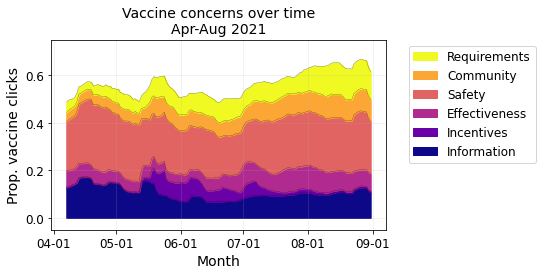

In [35]:
cmap = matplotlib.cm.get_cmap('plasma')
normalized_ratios = np.linspace(0, 1, len(cat_ratios))  # space evenly so we get contrast
cat2color = {c:cmap(r) for c, r in zip(cat_ratios.index.values, normalized_ratios)}

ax = plot_category_proportions_over_time(dates_to_plot, all_props, cat2color=cat2color)
ax.set_title('Vaccine concerns over time\nApr-Aug 2021', fontsize=14)
ax.set_ylim(-0.05, 0.75)
ax.tick_params(labelsize=12)
plt.savefig(os.path.join(PATH_TO_RESULTS, 'holdout_and_nonholdout_concerns_over_time.pdf'), bbox_inches='tight')

Information: mean prop = 0.09768
Incentives: mean prop = 0.02137
Effectiveness: mean prop = 0.05952
Safety: mean prop = 0.22808
Community: mean prop = 0.07306
Requirements: mean prop = 0.09287


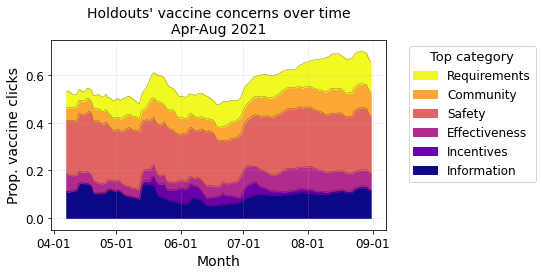

In [36]:
ax = plot_category_proportions_over_time(dates_to_plot, all_ho_props, cat2color=cat2color,
                                         legend_title='Top category')
ax.set_title('Holdouts\' vaccine concerns over time\nApr-Aug 2021', fontsize=14)
ax.set_ylim(-0.05, 0.75)
ax.tick_params(labelsize=12)
plt.savefig(os.path.join(PATH_TO_RESULTS, 'holdout_concerns_over_time.pdf'), bbox_inches='tight')

Information: mean prop = 0.10906
Incentives: mean prop = 0.03299
Effectiveness: mean prop = 0.07090
Safety: mean prop = 0.19315
Community: mean prop = 0.06465
Requirements: mean prop = 0.06519


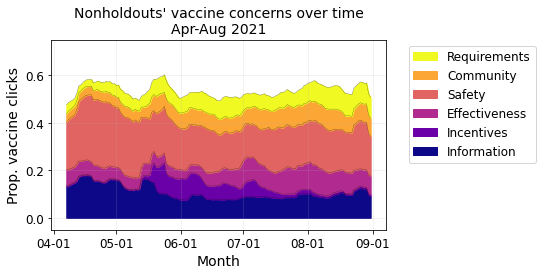

In [37]:
ax = plot_category_proportions_over_time(dates_to_plot, all_nh_props, cat2color=cat2color)
ax.set_title('Nonholdouts\' vaccine concerns over time\nApr-Aug 2021', fontsize=14)
ax.set_ylim(-0.05, 0.75)
ax.tick_params(labelsize=12)
plt.savefig(os.path.join(PATH_TO_RESULTS, 'nonholdout_concerns_over_time.pdf'), bbox_inches='tight')

## Apr-Jun holdout vs nonholdout comparison

0    207698
1    207074
Name: label, dtype: int64
0    309112
1    143909
Name: label, dtype: int64
36 (0.9683583360114295, 4.470467369332976e-22)


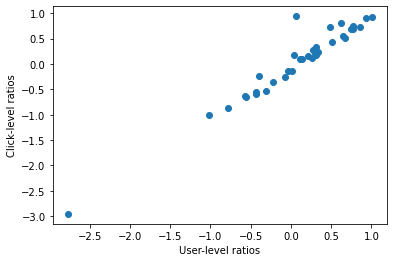

In [38]:
# ratios, user-level
weighted_ratios = compute_topic_ratios(zcta_cid_df, subcats_to_keep, weight_by_coverage=True)
# ratios, click-level
click_ratios = compute_topic_ratios(apr_jun_clicks_df, subcats_to_keep, weight_by_coverage=True)

# check agreement
x = np.log(weighted_ratios.loc[subcats_to_keep].ratio.values)
y = np.log(click_ratios.loc[subcats_to_keep].ratio.values)
print(len(x), pearsonr(x, y))
plt.scatter(x, y)
plt.xlabel('User-level ratios')
plt.ylabel('Click-level ratios')
plt.show()

In [ ]:
# bootstrap CIs for click-level
all_cats = list(subcats_to_keep) + list(cats_to_keep)
kwargs = {'weight_by_coverage': True}
bootstrapped_ratios = get_bootstrapped_topic_ratios(apr_jun_clicks_df, 
                            all_cats, kwargs, num_trials=1000)
assert np.isclose(bootstrapped_ratios.loc[subcats_to_keep].point_est.values, click_ratios.loc[subcats_to_keep].ratio.values).all()
with open(os.path.join(PATH_TO_RESULTS, 'click_ratios.pkl'), 'wb') as f:
    pickle.dump(bootstrapped_ratios, f)
bootstrapped_ratios

In [26]:
with open(os.path.join(PATH_TO_RESULTS, 'click_ratios.pkl'), 'rb') as f:
    bootstrapped_ratios = pickle.load(f)
cat_ratios = bootstrapped_ratios.loc[cats_to_keep].sort_values('point_est', ascending=False)
cat_ratios[['point_est', 'lower', 'upper']].round(2)

,point_est,lower,upper
category,,,
Other,1.62,1.57,1.68
Requirements,1.58,1.55,1.63
Community,1.24,1.20,1.27
Safety,1.01,0.99,1.02
Effectiveness,0.84,0.82,0.87
Incentives,0.79,0.75,0.82
Information,0.72,0.71,0.74
Availability,0.22,0.21,0.24


30


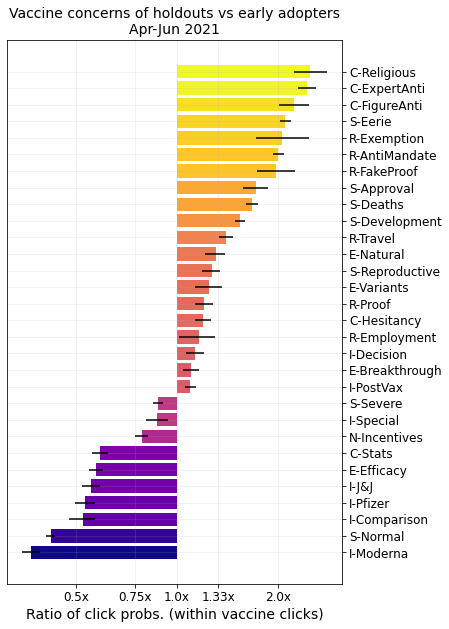

In [28]:
# plot click-level results
with open(os.path.join(PATH_TO_RESULTS, 'click_ratios.pkl'), 'rb') as f:
    bootstrapped_ratios = pickle.load(f)
    
click_ratios = click_ratios.sort_values('ratio')  # sort ascending for bar graph order
to_keep = [c for c in click_ratios.index if c not in to_drop]
print(len(to_keep))

cmap = matplotlib.cm.get_cmap('plasma')
log_ratio = np.log(click_ratios.loc[to_keep].ratio.values)
normalized_ratios = (log_ratio - np.min(log_ratio)) / (np.max(log_ratio)-np.min(log_ratio))
subcat2color = {s:cmap(r) for s, r in zip(to_keep, normalized_ratios)}
colors = [subcat2color[s] for s in to_keep]
xticks = np.array([0.5, 0.75, 1.0, 1.33, 2])
ax = plot_ratios_across_topics(bootstrapped_ratios, to_keep, xticks,
                               with_err=True, colors=colors)
ax.yaxis.set_label_position('right')  # label on the right
ax.yaxis.tick_right()
ax.set_title('Vaccine concerns of holdouts vs early adopters\nApr-Jun 2021', fontsize=14)
plt.savefig(os.path.join(PATH_TO_RESULTS, 'holdout_vs_nonholdout_concerns.pdf'), bbox_inches='tight')

In [ ]:
# comparing holdouts within demographics
# get bootstrapped ratios of holdouts above and below median
group2ratios = {}
demo_cols = ['median_income', 'prop_rep', 'percent_white', 'percent_65_and_over']
kwargs = {'weight_by_coverage': True}
holdouts_clicks_df = apr_jun_clicks_df[apr_jun_clicks_df.label == 1]
print(len(holdouts_clicks_df))

for demo_col in demo_cols:
    print(demo_col)
    cutoff = zcta_df[demo_col].quantile(0.5)
    top_zctas = zcta_df[zcta_df[demo_col] >= cutoff].index.values  # above median
    new_apr_jun_clicks_df = holdouts_clicks_df.copy()
    new_apr_jun_clicks_df['label'] = new_apr_jun_clicks_df.ZCTA.isin(top_zctas).astype(int)
    # compare holdouts from ZCTAs above median vs ZCTAs below median
    group2ratios[demo_col] = get_bootstrapped_topic_ratios(
        new_apr_jun_clicks_df, subcats_to_keep, kwargs, num_trials=1000)
with open(os.path.join(PATH_TO_RESULTS, 'group2ratios.pkl'), 'wb') as f:
    pickle.dump(group2ratios, f)

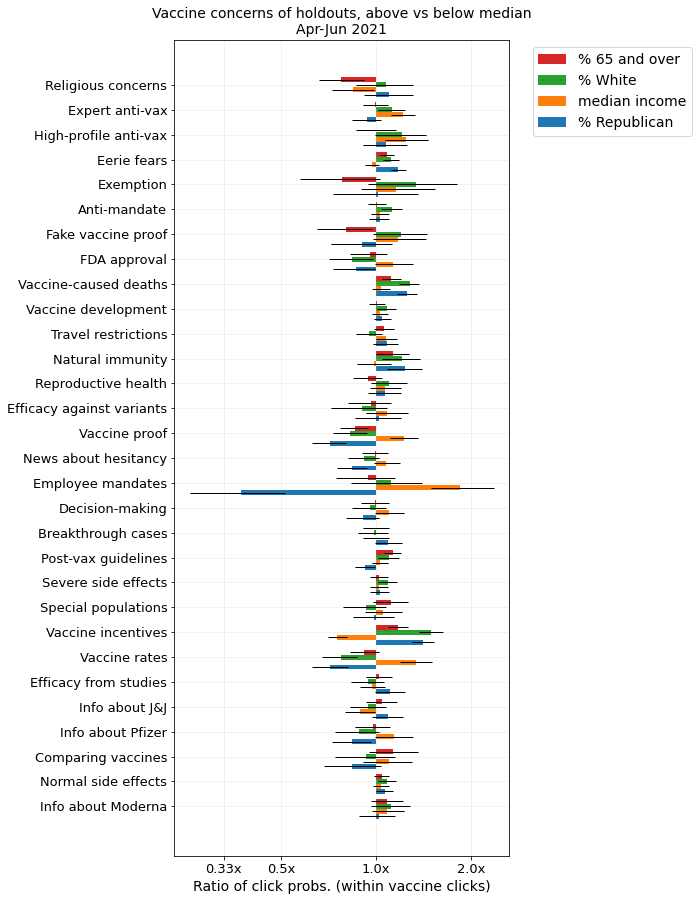

In [34]:
# plot bootstrapped ratios of holdouts above and below median
with open(os.path.join(PATH_TO_RESULTS, 'group2ratios.pkl'), 'rb') as f:
    group2ratios = pickle.load(f)
demo_cols = ['prop_rep', 'median_income', 'percent_white', 'percent_65_and_over']
cols_for_group = to_keep  # [-10:]  # top 10 most holdout-leaning subcategories
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots(figsize=(6,15))
bar_height = 5
interval = bar_height*(len(demo_cols)+1)
yticks = np.arange(0, len(cols_for_group)*interval, interval)

for i, demo_col in enumerate(demo_cols):
    label = cu.get_print_name_for_col(demo_col)
    ratios = group2ratios[demo_col]
    log_ratio = np.log(ratios.loc[cols_for_group].point_est.values)
    lower = np.log(ratios.loc[cols_for_group].lower.values)
    upper = np.log(ratios.loc[cols_for_group].upper.values)
    err = [log_ratio-lower, upper-log_ratio]
    ax.barh(yticks+(i*bar_height), log_ratio, align='center', height=bar_height, 
            label=label, color=colors[i], xerr=err, ecolor='black', error_kw={'elinewidth': 1})
    
ax.set_title('Vaccine concerns of holdouts, above vs below median\nApr-Jun 2021', fontsize=14)
ax.set_xlabel('Ratio of click probs. (within vaccine clicks)', fontsize=14)
subcat_labels = [cu.SUBCAT_KEY_TO_NAME[c] for c in cols_for_group]
ax.set_yticks(yticks + (bar_height*len(demo_cols))/2, labels=subcat_labels)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=14)
ax.grid(alpha=0.2)
xticks = np.array([0.33, 0.5, 1.0, 2])
xtick_labels = ['%sx' % t for t in xticks]
ax.set_xticks(np.log(xticks), labels=xtick_labels)
ax.tick_params(labelsize=13)
plt.savefig(os.path.join(PATH_TO_RESULTS, 'holdout_concerns_demo.pdf'), bbox_inches='tight')

## Timing with vaccine intent

In [ ]:
# load vaccine intent queries and clicks
all_vi = []
amt_pos_urls, gnn_pos_urls = load_positive_urls()
date_ranges = cu.DATE_RANGES[-2:]
for date_range in date_ranges:
    month = date_range.split('-')[1]
    print(date_range, month)
    fn = os.path.join(cu.PATH_TO_BING_DATA, 'vaccine_intent_queries_%s.tsv' % date_range)
    query_df = pd.read_csv(fn, delimiter='\t', header=0, quoting=csv.QUOTE_NONE, on_bad_lines='skip')
    print('Loaded vaccine intent queries, len =', len(query_df))
    fn = os.path.join(cu.PATH_TO_BING_DATA, 'vaccine_intent_clicks_%s.tsv' % date_range)
    click_df = pd.read_csv(fn, delimiter='\t', header=0, quoting=csv.QUOTE_NONE, on_bad_lines='skip')
    print('Loaded vaccine intent clicks, len =', len(click_df))
    in_amt = click_df.ClickUrl.isin(amt_pos_urls)
    in_gnn = click_df.ClickUrl.isin(gnn_pos_urls)
    matches_regex = click_df.ClickUrl.apply(is_vaccine_intent_url)
    label_source = np.zeros(len(click_df)) * np.nan
    label_source[matches_regex] = 0
    label_source[in_amt] = 1  # overrides regex
    label_source[in_gnn] = 2  # overrides regex
    click_df['UrlLabelSource'] = label_source
    missing_source = click_df.UrlLabelSource.isnull()
    if missing_source.sum() > 0:
        print('Warning: %d URLs missing label source' % missing_source.sum())
    # combine queries and clicks - we can still distinguish them with missing cols
    all_vi.append(pd.concat([query_df, click_df]))
all_vi_df = pd.concat(all_vi)
print(len(all_vi_df))
all_vi_df['datetime'] = all_vi_df.Request_RequestTime.apply(cu.extract_datetime)  # get day

In [ ]:
# holdouts in July and August
# annotate whether click happened within range of vaccine intent
jul_aug_clicks_df = all_clicks_df[all_clicks_df.date_range.isin(date_ranges[-2:]) & (all_clicks_df.label == 1)].copy()
print(jul_aug_clicks_df.date_range.value_counts())
jul_aug_clicks_df = add_time_to_vi_to_clicks_df(jul_aug_clicks_df, all_vi_df, 
                                datetime.datetime(2021, 7, 1), datetime.datetime(2021, 8, 31),
                                days_before=14, days_after=7)
# merge with ZCTA info
orig_len = len(jul_aug_clicks_df)
jul_aug_clicks_df = jul_aug_clicks_df.merge(zcta_cid_df[['MaxState', 'MaxCounty', 'ZCTA', 'inverse_coverage']], how='inner',
                                 left_on='ClientId', right_index=True)
print(len(jul_aug_clicks_df), orig_len)

In [ ]:
# bootstrap CIs for manual
all_cats = list(subcats_to_keep) + list(cats_to_keep)
kwargs = {'weight_by_coverage': True, 'label_col': 'in_manual_vi_range'}
bootstrapped_ratios = get_bootstrapped_topic_ratios(jul_aug_clicks_df, 
                            all_cats, kwargs, num_trials=1000)
assert np.isclose(bootstrapped_ratios.loc[subcats_to_keep].point_est.values, vi_ratios.loc[subcats_to_keep].ratio.values).all()
with open(os.path.join(PATH_TO_RESULTS, 'manual_vi_ratios.pkl'), 'wb') as f:
    pickle.dump(bootstrapped_ratios, f)

In [77]:
with open(os.path.join(PATH_TO_RESULTS, 'manual_vi_ratios.pkl'), 'rb') as f:
    bootstrapped_ratios = pickle.load(f)
cat_ratios = bootstrapped_ratios.loc[cats_to_keep].sort_values('point_est', ascending=False)
cat_ratios[['point_est', 'lower', 'upper']].round(2)

,point_est,lower,upper
category,,,
Availability,4.68,4.49,4.88
Incentives,2.46,2.30,2.61
Information,1.39,1.36,1.42
Safety,0.82,0.81,0.84
Effectiveness,0.80,0.77,0.83
Requirements,0.61,0.59,0.63
Other,0.58,0.54,0.62
Community,0.57,0.54,0.59


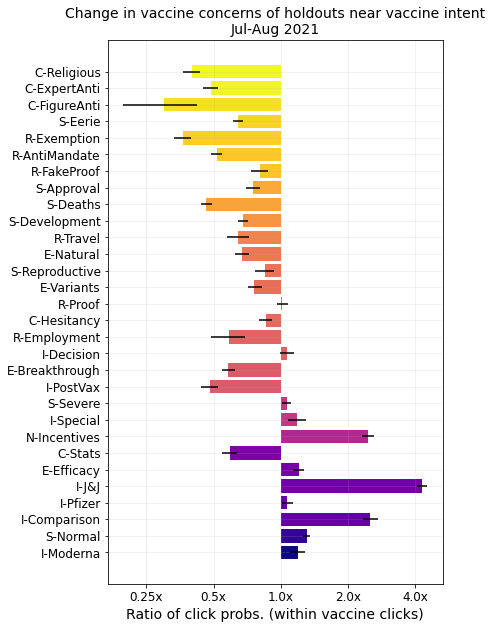

In [68]:
with open(os.path.join(PATH_TO_RESULTS, 'manual_vi_ratios.pkl'), 'rb') as f:
    bootstrapped_ratios = pickle.load(f)
# use colors and topic ordering from holdout vs early adopter comparison
colors = [subcat2color[c] for c in to_keep]
xticks = np.array([1/4, 1/2, 1.0, 2, 4])
ax = plot_ratios_across_topics(bootstrapped_ratios, to_keep, xticks, colors=colors, with_err=True)
ax.set_title('Vaccine concerns of holdouts near vaccine intent vs not\nJul-Aug 2021', fontsize=14)
plt.savefig(os.path.join(PATH_TO_RESULTS, 'holdout_concerns_in_range_vaccine_intent.pdf'), bbox_inches='tight')

# Supplementary

## Topic dynamics

In [ ]:
days_before = 14
days_after = 7
days_in_range_indices = range(-days_before, days_after+1)
in_range_cols = ['is_t%s' % i for i in days_in_range_indices]
jul_aug_clicks_df['not_in_range'] = ~(jul_aug_clicks_df[in_range_cols].any(axis=1))
t2ratios = {}
for t in days_in_range_indices:
    kwargs = {'weight_by_coverage': True, 'label_col': 'is_t%s' % t,
              'neg_col': 'not_in_range', 'verbose': False}
    print(t)
    t2ratios[t] = get_bootstrapped_topic_ratios(jul_aug_clicks_df, to_keep, kwargs, 
                                                num_trials=100)
with open(os.path.join(PATH_TO_RESULTS, 'subcat_dynamics_conditional.pkl'), 'wb') as f:
    pickle.dump(t2ratios, f)

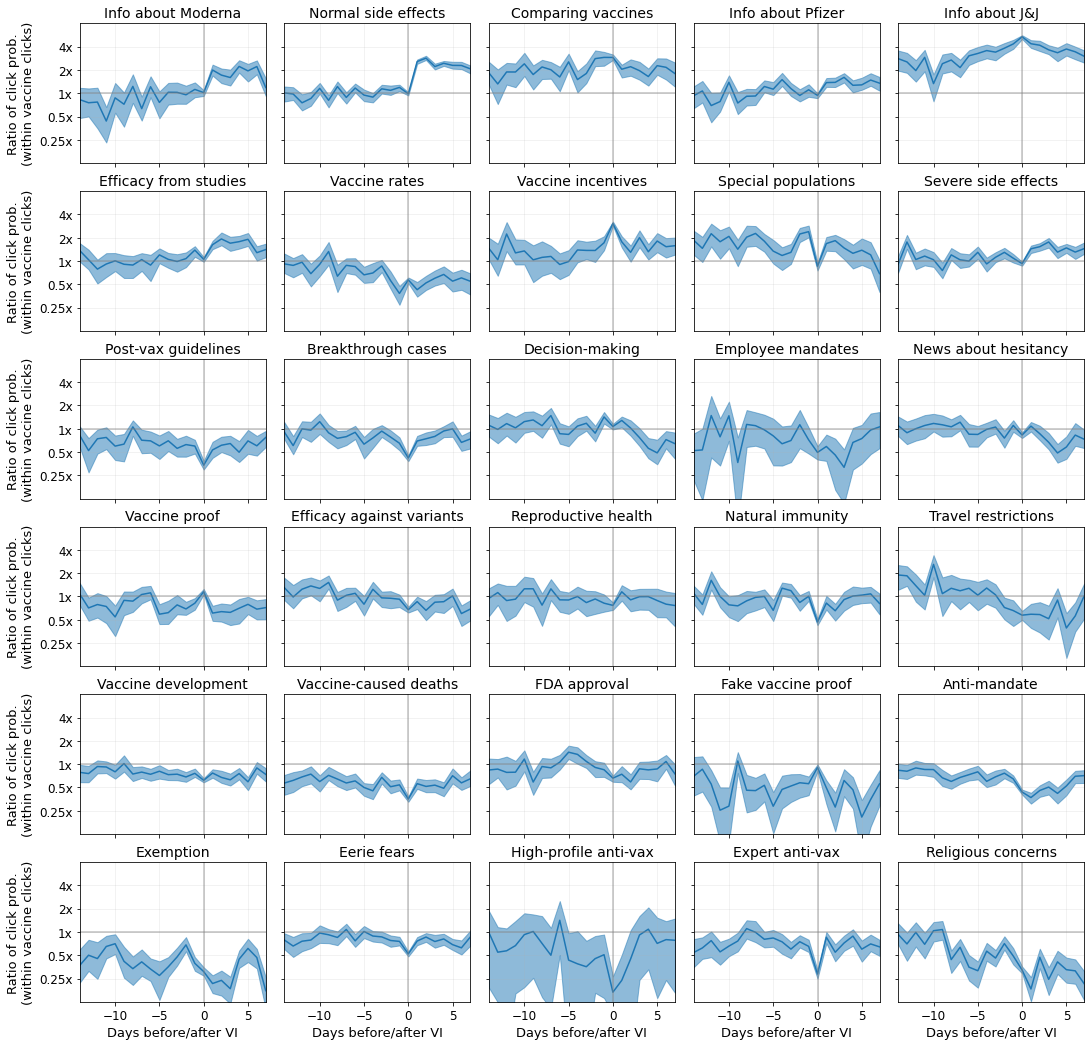

In [127]:
# Pr(subcat | day k, vaccine-related) / Pr(subcat | not in range, vaccine-related)
with open(os.path.join(PATH_TO_RESULTS, 'subcat_dynamics_conditional.pkl'), 'rb') as f:
    t2ratios = pickle.load(f)
fig, axes = plt.subplots(6, 5, figsize=(18, 18), sharey=True, sharex=True)
axes = axes.flatten()
fig.subplots_adjust(wspace=0.1)
assert len(axes) == len(to_keep)
i = 0
yticks = [0.25, 0.5, 1, 2, 4]
ymin = np.log(1/8)
ymax = np.log(8)
for s, ax in zip(to_keep, axes):
    ax = plot_subcat_dynamics(t2ratios, s, days_in_range_indices, ax=ax, yticks=yticks)
    ax.set_title(cu.SUBCAT_KEY_TO_NAME[s], fontsize=14)
    if (i >= 25):
        ax.set_xlabel('Days before/after VI', fontsize=13)
    if (i % 5 == 0):
        ax.set_ylabel('Ratio of click prob.\n(within vaccine clicks)', fontsize=13)
    ax.set_ylim(ymin, ymax)
    ax.vlines([0], ymin, ymax, color='grey', alpha=0.5)
    i += 1
plt.savefig(os.path.join(PATH_TO_RESULTS, 'subcategory_dynamics_conditional.pdf'), bbox_inches='tight')

In [ ]:
# convert to user, date dataframe, with 1 indicating at least one click on that day
cols_to_agg = ['about_vaccine'] + list(subcats_to_keep)
users = sorted(jul_aug_clicks_df.ClientId.unique())
dates = sorted(jul_aug_clicks_df.datetime.unique())
users_repeated = np.repeat(users, len(dates))
dates_repeated = np.tile(dates, len(users))
user_date_df = pd.DataFrame({'ClientId': users_repeated, 'datetime': dates_repeated}).set_index(['ClientId', 'datetime'])
print(len(users), len(dates), len(user_date_df))
# take max of cols_to_agg
user_date_clicks = jul_aug_clicks_df.groupby(['ClientId', 'datetime'])[cols_to_agg].max().astype(int)
user_date_df = pd.merge(user_date_df, user_date_clicks, how='left', left_index=True, right_index=True).fillna(0)
user_date_df.head()

In [106]:
# label day relative to vaccine intent days
user_date_df = user_date_df.reset_index()
total_conversion_days = days_before + days_after + 1
for i in days_in_range_indices:
    user_date_df['is_t%s' % i] = np.zeros(len(user_date_df)).astype(bool)

t = datetime.datetime(2021, 7, 1)
while t <= datetime.datetime(2021, 8, 31):
    print(t)
    users_on_day = all_vi_df[(all_vi_df.datetime == t) & (all_vi_df.UrlLabelSource != 2)].ClientId.values
    days_in_range = cu.get_datetimes_in_range(t + datetime.timedelta(days=-days_before), t + datetime.timedelta(days=days_after))    
    for i, day in zip(days_in_range_indices, days_in_range):
        # click is t+i days away from VI
        matches_day = user_date_df.ClientId.isin(users_on_day) & (user_date_df.datetime == day)
        col = 'is_t%s' % i
        # this should be our first time seeing this day as t+i for this specific t
        assert (~user_date_df[col][matches_day]).all()
        user_date_df[col] = user_date_df[col] | matches_day
    t = t + datetime.timedelta(days=1)

2021-07-01 00:00:00
2021-07-02 00:00:00
2021-07-03 00:00:00
2021-07-04 00:00:00
2021-07-05 00:00:00
2021-07-06 00:00:00
2021-07-07 00:00:00
2021-07-08 00:00:00
2021-07-09 00:00:00
2021-07-10 00:00:00
2021-07-11 00:00:00
2021-07-12 00:00:00
2021-07-13 00:00:00
2021-07-14 00:00:00
2021-07-15 00:00:00
2021-07-16 00:00:00
2021-07-17 00:00:00
2021-07-18 00:00:00
2021-07-19 00:00:00
2021-07-20 00:00:00
2021-07-21 00:00:00
2021-07-22 00:00:00
2021-07-23 00:00:00
2021-07-24 00:00:00
2021-07-25 00:00:00
2021-07-26 00:00:00
2021-07-27 00:00:00
2021-07-28 00:00:00
2021-07-29 00:00:00
2021-07-30 00:00:00
2021-07-31 00:00:00
2021-08-01 00:00:00
2021-08-02 00:00:00
2021-08-03 00:00:00
2021-08-04 00:00:00
2021-08-05 00:00:00
2021-08-06 00:00:00
2021-08-07 00:00:00
2021-08-08 00:00:00
2021-08-09 00:00:00
2021-08-10 00:00:00
2021-08-11 00:00:00
2021-08-12 00:00:00
2021-08-13 00:00:00
2021-08-14 00:00:00
2021-08-15 00:00:00
2021-08-16 00:00:00
2021-08-17 00:00:00
2021-08-18 00:00:00
2021-08-19 00:00:00


In [ ]:
user_date_df['not_in_range'] = ~(user_date_df[in_range_cols].any(axis=1))
t2ratios_2 = {}
for t in days_in_range_indices:
    kwargs = {'weight_by_coverage': False, 'label_col': 'is_t%s' % t,
              'neg_col': 'not_in_range', 'verbose': False}
    t2ratios_2[t] = compute_topic_ratios(user_date_df, to_keep, **kwargs)

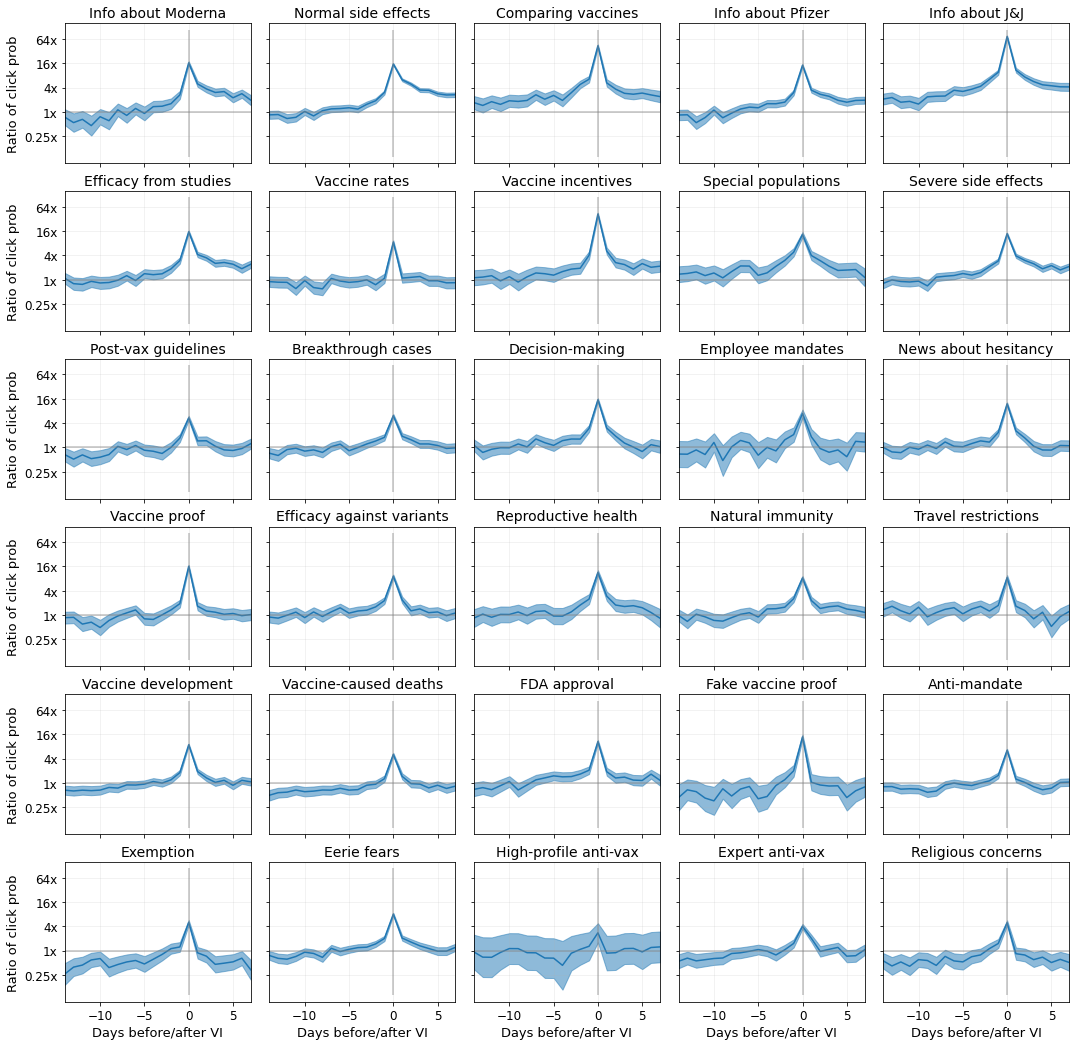

In [141]:
# Pr(subcat | day k) / Pr(subcat | not in range)
fig, axes = plt.subplots(6, 5, figsize=(18, 18), sharey=True, sharex=True)
axes = axes.flatten()
fig.subplots_adjust(wspace=0.1)
assert len(axes) == len(to_keep)
i = 0
yticks = [0.25, 1, 4, 16, 64]
for s, ax in zip(to_keep, axes):
    ax = plot_subcat_dynamics(t2ratios_2, s, days_in_range_indices, ax=ax, yticks=yticks)
    ax.set_title(cu.SUBCAT_KEY_TO_NAME[s], fontsize=14)
    if (i >= 25):
        ax.set_xlabel('Days before/after VI', fontsize=13)
    if (i % 5 == 0):
        ax.set_ylabel('Ratio of click prob', fontsize=13)
    i += 1
ymin, ymax = axes[0].get_ylim()
for ax in axes:
    ax.vlines([0], ymin, ymax, color='grey', alpha=0.5)
plt.savefig(os.path.join(PATH_TO_RESULTS, 'subcategory_dynamics.pdf'), bbox_inches='tight')

## Logistic regression of vaccine intent change

In [75]:
import statsmodels.api as sm

In [91]:
# try effect of controlling for time
conversion_X = jul_aug_clicks_df.in_manual_vi_range.values.reshape(-1, 1)
dates = sorted(jul_aug_clicks_df.datetime.unique())
print(len(dates))
date_X = np.zeros((len(jul_aug_clicks_df), len(dates)), dtype=int)
for t, d in enumerate(dates):
    matches_date = (jul_aug_clicks_df.datetime == d).values
    matches_date_indices = np.arange(len(jul_aug_clicks_df))[matches_date]
    date_X[matches_date_indices, t] = 1
all_X = np.concatenate([date_X, conversion_X], axis=1)
print(all_X.shape)
dummy = np.ones(len(y)).reshape(-1, 1)  # just an intercept
nested_X = np.concatenate([dummy, conversion_X], axis=1)
print(nested_X.shape)

62
(464903, 63)
(464903, 2)


In [93]:
# fit full vs nested model
# see if there is any significant change in conversion parameter
subcat2summary = {}
for s in subcats_to_keep:
    ts = time.time()
    y = jul_aug_clicks_df[s].values
    log_reg = sm.Logit(y, all_X).fit()
    summ_full = log_reg.summary2().tables[1]
    convert_param_results_full = summ_full.values[-1]
    full_est, full_lower, full_upper = convert_param_results_full[[0, -2, -1]]
    
    log_reg = sm.Logit(y, nested_X).fit()
    summ_nested = log_reg.summary2().tables[1]
    convert_param_results_nested = summ_nested.values[-1]
    nested_est, nested_lower, nested_upper = convert_param_results_nested[[0, -2, -1]]
    subcat2summary[s] = (summ_full, summ_nested)

    print('%s [time=%.2fs]: full = %.3f (%.3f, %.3f), nested = %.3f (%.3f, %.3f) -> %s' % (
        s, time.time()-ts, full_est, full_lower, full_upper, 
        nested_est, nested_lower, nested_upper, 
        (nested_lower > full_upper) or (full_lower > nested_upper)))
with open(os.path.join(PATH_TO_RESULTS, 'sm_logit_results_conversion_binary.pkl'), 'wb') as f:
    pickle.dump(subcat2summary, f)

Optimization terminated successfully.
         Current function value: 0.213489
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.213805
         Iterations 7
S-Normal [time=7.30s]: full = 0.288 (0.255, 0.322), nested = 0.285 (0.251, 0.319) -> False
Optimization terminated successfully.
         Current function value: 0.155283
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.155817
         Iterations 7
S-Severe [time=7.35s]: full = 0.076 (0.032, 0.121), nested = 0.064 (0.020, 0.108) -> False
Optimization terminated successfully.
         Current function value: 0.058699
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.058878
         Iterations 9
S-Reproductive [time=8.32s]: full = -0.186 (-0.274, -0.098), nested = -0.187 (-0.275, -0.099) -> False
Optimization terminated successfully.
         Current function value: 0.182917
         Iterations 8
O

/home/t-sechang/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.013547
         Iterations 11
C-FigureAnti [time=21.34s]: full = -1.258 (-1.588, -0.928), nested = -1.256 (-1.585, -0.927) -> False
Optimization terminated successfully.
         Current function value: 0.110246
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.112377
         Iterations 9
C-Religious [time=8.55s]: full = -0.961 (-1.040, -0.881), nested = -0.937 (-1.017, -0.857) -> False
Optimization terminated successfully.
         Current function value: 0.035551
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.035731
         Iterations 11
A-Locations [time=9.65s]: full = 3.618 (3.527, 3.708), nested = 3.620 (3.530, 3.710) -> False
Optimization terminated successfully.
         Current function value: 0.042065
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.042491
        

/home/t-sechang/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.044276
         Iterations 9
A-Boosters [time=20.39s]: full = 0.708 (0.630, 0.786), nested = 0.733 (0.655, 0.810) -> False
Optimization terminated successfully.
         Current function value: 0.085840
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.086135
         Iterations 8
I-Decision [time=8.41s]: full = 0.033 (-0.032, 0.097), nested = 0.033 (-0.032, 0.097) -> False
Optimization terminated successfully.
         Current function value: 0.055077
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.055321
         Iterations 9
I-Comparison [time=8.48s]: full = 0.944 (0.880, 1.008), nested = 0.946 (0.882, 1.010) -> False
Optimization terminated successfully.
         Current function value: 0.067309
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.068091
         Iterations 8
I

/home/t-sechang/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.030718
         Iterations 10
R-Employment [time=20.68s]: full = -0.553 (-0.701, -0.404), nested = -0.520 (-0.668, -0.372) -> False
Optimization terminated successfully.
         Current function value: 0.098476
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.100006
         Iterations 8
R-Proof [time=8.49s]: full = 0.017 (-0.041, 0.076), nested = 0.042 (-0.016, 0.101) -> False
Optimization terminated successfully.
         Current function value: 0.108161
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.111800
         Iterations 9
R-Exemption [time=9.41s]: full = -1.049 (-1.132, -0.966), nested = -1.020 (-1.103, -0.938) -> False
Optimization terminated successfully.
         Current function value: 0.058823
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.059866
         It

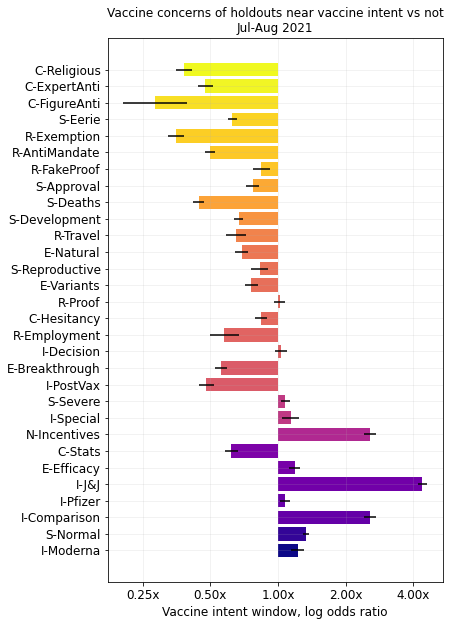

In [94]:
with open(os.path.join(PATH_TO_RESULTS, 'sm_logit_results_conversion_binary.pkl'), 'rb') as f:
    subcat2summary = pickle.load(f)
bootstrapped_ratios = []
for s in subcats_to_keep:
    summ = subcat2summary[s][0]
    convert_param_results = summ.values[-1]
    bootstrapped_ratios.append({'category': s, 'point_est': convert_param_results[0],
                                'lower': convert_param_results[-2], 
                                'upper': convert_param_results[-1]})
columns = ['category', 'point_est', 'lower', 'upper']
bootstrapped_ratios = pd.DataFrame(bootstrapped_ratios, columns=columns).set_index('category')

# use colors and topic ordering from holdout vs early adopter comparison
# looks near identical to previous plot
colors = [subcat2color[c] for c in to_keep]
fig, ax = plt.subplots(figsize=(6,10))
x = bootstrapped_ratios.loc[to_keep].point_est.values
lower = bootstrapped_ratios.loc[to_keep].lower.values
upper = bootstrapped_ratios.loc[to_keep].upper.values
err = [x-lower, upper-x]
ax.barh(to_keep, x, color=colors, align='center', xerr=err, ecolor='black')
ax.grid(alpha=0.2)
ax.tick_params(labelsize=12)
xticks = np.array([1/4, 1/2, 1.0, 2, 4])
xtick_labels = ['%.2fx' % t for t in xticks]
ax.set_xticks(np.log(xticks), labels=xtick_labels)
ax.set_xlabel('Vaccine intent window, log odds ratio', fontsize=12)
ax.set_title('Vaccine concerns of holdouts near vaccine intent vs not\nJul-Aug 2021', fontsize=12)
plt.savefig(os.path.join(PATH_TO_RESULTS, 'holdout_concerns_in_range_vaccine_intent_logit.pdf'), bbox_inches='tight')